In [1]:
import postprocessing
import matplotlib.pyplot as plt
import yt
import math
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
from pathlib import Path
Path("figures").mkdir(parents=True, exist_ok=True)

/home/dbeckers/.conda/envs/postprocessing_v2/lib/python3.9/site-packages/yt/utilities/logger.py:4: VisibleDeprecationWarning: The configuration file /home/dbeckers/.config/yt/ytrc is deprecated in favor of /home/dbeckers/.config/yt/yt.toml. Currently, both are present. Please manually remove the deprecated one to silence this warning.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  from yt.config import ytcfg


In [2]:
yt.set_log_level(50)

In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
class OneDimScalarDistribution:
    def __init__(self, name, u, x0, amplitude, width, wavenumber):
        self.name = name
        self.u = u
        self.x0 = x0
        self.amplitude = amplitude
        self.width = width
        self.wavenumber = wavenumber

In [5]:
class GaussianPulse(OneDimScalarDistribution):
    def exact_solution(self, x, t):
        convected_distance = self.u * t
        if (abs((x-convected_distance) - self.x0) < 6 * self.width):
            return self.amplitude * math.exp( - ((x - convected_distance) - self.x0) ** 2 / (2 * self.width ** 2))
        else:
            return 0.0

In [6]:
class SquarePulse(OneDimScalarDistribution):
    def exact_solution(self, x, t):
        convected_distance = self.u * t
        if (abs((x-convected_distance) - self.x0) < 0.5 * self.width):
            return self.amplitude
        else:
            return 0.0

In [7]:
class GaussianWavePacket(OneDimScalarDistribution):
    def exact_solution(self, x, t):
        convected_distance = self.u * t
        if (abs((x-convected_distance) - self.x0) < 6 * self.width):
            return math.cos(self.wavenumber * (x-convected_distance)) * self.amplitude * math.exp( - ((x-convected_distance) - self.x0) ** 2 / (2 * self.width ** 2))
        else:
            return 0.0

In [8]:
x_exact = np.linspace(0, 1, num=2000)
lw_exact = 0.5
ls_exact = 'dashed'

In [9]:
root_dir = '/scratch/dbeckers/scalar_advection'

## Gaussian pulse - uniform grid

In [10]:
gaussianpulse = GaussianPulse("gaussianpulse_CFL_0.45",1.0,0.25,1.0,0.01,0)
case_dir = gaussianpulse.name+"/uniform"
methods = ['godunov_ppm','godunov_ppm_nolim','godunov_weno_z','godunov_bds']
grid_sizes = [128]
maxlevel = 0
withglobal = False

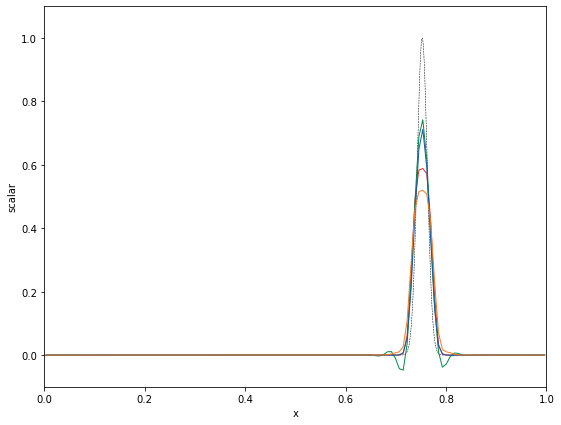

In [11]:
fig,ax = plt.subplots(figsize=(9,7))
ax.plot(x_exact,[gaussianpulse.exact_solution(x_i,0.502734) for x_i in x_exact],label='exact',linewidth=lw_exact,linestyle=ls_exact,color='black')
postprocessing.batch_plot_ray(ax,root_dir,case_dir,methods,grid_sizes,-1,(0,0,0),(1,0,0),use_ray_coord=False,color_methods=True,variable='temperature')
ax.set_xlim(0,1)
ax.set_ylim(-0.1,1.1)
ax.set_xlabel('x')
ax.set_ylabel('scalar')
fig.savefig(f'figures/{gaussianpulse.name}_uniform_distribution.png',dpi=300)

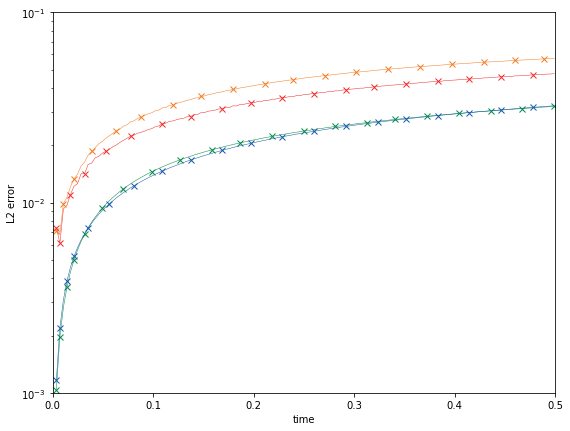

In [12]:
fig,ax = plt.subplots(figsize=(9,7))
postprocessing.batch_plot_error(ax,'error.log',root_dir,case_dir,methods,grid_sizes,0.5,with_global=False,max_level=0,line_width=0.5)
ax.set_xlim(0,0.5)
ax.set_ylim(1e-3,1e-1)
ax.set_yscale('log')
ax.set_xlabel('time')
ax.set_ylabel('L2 error')
fig.savefig(f'figures/{gaussianpulse.name}_uniform_error.png',dpi=300)

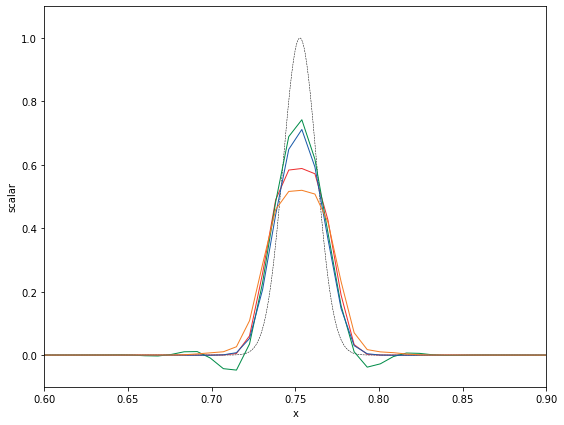

In [13]:
fig,ax = plt.subplots(figsize=(9,7))
ax.plot(x_exact,[gaussianpulse.exact_solution(x_i,0.502734) for x_i in x_exact],label='exact',linewidth=lw_exact,linestyle=ls_exact,color='black')
postprocessing.batch_plot_ray(ax,root_dir,case_dir,methods,grid_sizes,-1,(0,0,0),(1,0,0),use_ray_coord=False,color_methods=True,variable='temperature')
ax.set_xlim(0.6,0.9)
ax.set_ylim(-0.1,1.1)
ax.set_xlabel('x')
ax.set_ylabel('scalar')
fig.savefig(f'figures/{gaussianpulse.name}_uniform_distribution_centered.png',dpi=300)

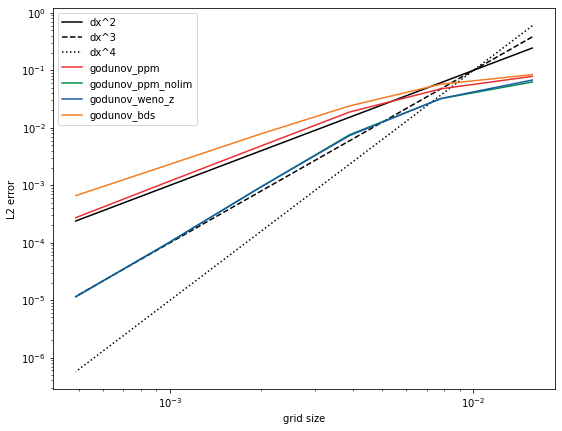

In [14]:
grid_sizes = [64,128,256,512,1024,2048]
dx_list = [1.0/grid_size for grid_size in grid_sizes]
error_list = postprocessing.batch_load_error('error.log',root_dir,case_dir,methods,grid_sizes,load_global=False)
fig,ax = plt.subplots(figsize=[9,7])
ax.plot(dx_list,[1e3*dx**2 for dx in dx_list],label='dx^2',linestyle='solid',color='black')
ax.plot(dx_list,[1e5*dx**3 for dx in dx_list],label='dx^3',linestyle='dashed',color='black')
ax.plot(dx_list,[1e7*dx**4 for dx in dx_list],label='dx^4',linestyle='dotted',color='black')
for i_method in range(len(methods)):
    ax.plot([1/grid_size for grid_size in grid_sizes],[df_error_grid['error_level_0'].values[-1] for df_error_grid in error_list[i_method]],label=methods[i_method],color=postprocessing.color_list[i_method])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('L2 error')
ax.set_xlabel('grid size')
ax.legend()
fig.savefig(f'figures/{gaussianpulse.name}_uniform_convergence.png',dpi=300)

## Gaussian wave packet - uniform grid

In [15]:
gaussianwavepacket = GaussianWavePacket("gaussianwavepacket_CFL_0.45",1.0,0.25,1.0,0.0251646060,226.1946710304)
case_dir = gaussianwavepacket.name+"/uniform"
methods = ['godunov_ppm','godunov_ppm_nolim','godunov_weno_z','godunov_bds','mol_central']
grid_sizes = [1024]
maxlevel = 0
withglobal = False

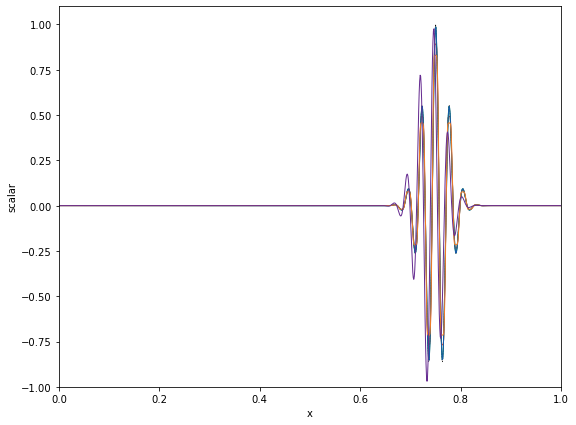

In [16]:
fig,ax = plt.subplots(figsize=(9,7))
ax.plot(x_exact,[gaussianwavepacket.exact_solution(x_i,0.5) for x_i in x_exact],label='exact',linewidth=lw_exact,linestyle=ls_exact,color='black')
postprocessing.batch_plot_ray(ax,root_dir,case_dir,methods,grid_sizes,-1,(0,0,0),(1,0,0),use_ray_coord=False,color_methods=True)
ax.set_xlim(0,1)
ax.set_ylim(-1.0,1.1)
ax.set_xlabel('x')
ax.set_ylabel('scalar')
fig.savefig(f'figures/{gaussianwavepacket.name}_uniform_distribution.png',dpi=300)

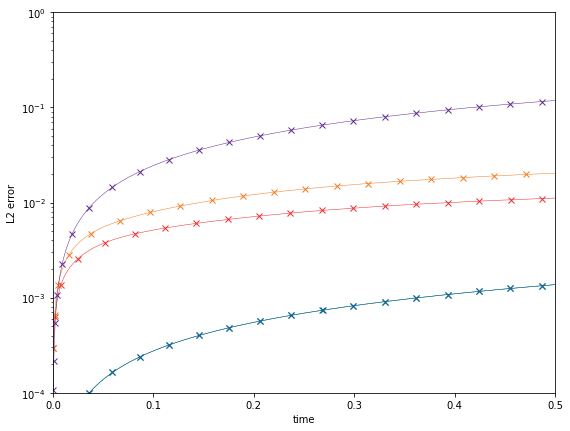

In [17]:
fig,ax = plt.subplots(figsize=(9,7))
postprocessing.batch_plot_error(ax,'error.log',root_dir,case_dir,methods,grid_sizes,0.5,with_global=False,max_level=0,line_width=0.5)
ax.set_ylim(1e-4,1e-0)
ax.set_xlim(0,0.5)
ax.set_yscale('log')
ax.set_xlabel('time')
ax.set_ylabel('L2 error')
fig.savefig(f'figures/{gaussianwavepacket.name}_uniform_error.png',dpi=300)

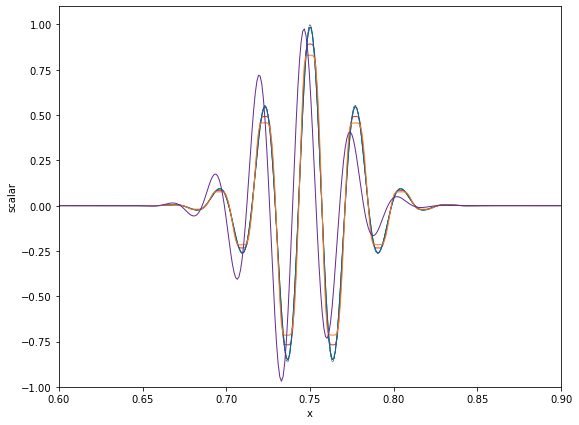

In [18]:
fig,ax = plt.subplots(figsize=(9,7))
ax.plot(x_exact,[gaussianwavepacket.exact_solution(x_i,0.5) for x_i in x_exact],label='exact',linewidth=lw_exact,linestyle=ls_exact,color='black')
postprocessing.batch_plot_ray(ax,root_dir,case_dir,methods,grid_sizes,-1,(0,0,0),(1,0,0),use_ray_coord=False,color_methods=True)
ax.set_xlim(0.6,0.9)
ax.set_ylim(-1.0,1.1)
ax.set_xlabel('x')
ax.set_ylabel('scalar')
fig.savefig(f'figures/{gaussianwavepacket.name}_uniform_distribution_centered.png',dpi=300)

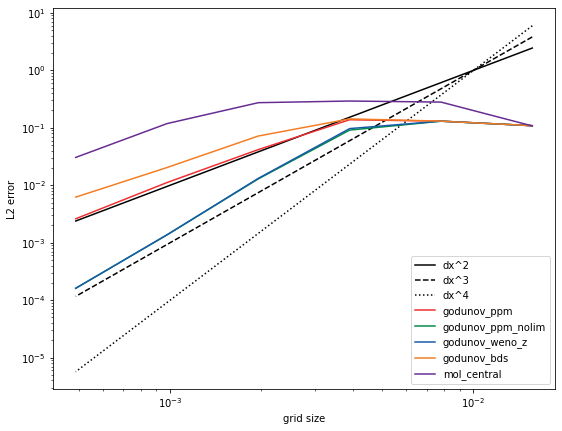

In [19]:
grid_sizes = [64,128,256,512,1024,2048]
dx_list = [1.0/grid_size for grid_size in grid_sizes]
error_list = postprocessing.batch_load_error('error.log',root_dir,case_dir,methods,grid_sizes,load_global=False)
fig,ax = plt.subplots(figsize=[9,7])
ax.plot(dx_list,[1e4*dx**2 for dx in dx_list],label='dx^2',linestyle='solid',color='black')
ax.plot(dx_list,[1e6*dx**3 for dx in dx_list],label='dx^3',linestyle='dashed',color='black')
ax.plot(dx_list,[1e8*dx**4 for dx in dx_list],label='dx^4',linestyle='dotted',color='black')
for i_method in range(len(methods)):
    ax.plot([1/grid_size for grid_size in grid_sizes],[df_error_grid['error_level_0'].values[-1] for df_error_grid in error_list[i_method]],label=methods[i_method],color=postprocessing.color_list[i_method])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('L2 error')
ax.set_xlabel('grid size')
ax.legend()
fig.savefig(f'figures/{gaussianwavepacket.name}_uniform_convergence.png',dpi=300)

## Gaussian wave packet - fine-to-coarse grid

In [20]:
gaussianwavepacket = GaussianWavePacket("gaussianwavepacket_CFL_0.45",1.0,0.25,1.0,0.0251646060,226.1946710304)
case_dir = gaussianwavepacket.name+"/fine_to_coarse"
methods = ['godunov_ppm','godunov_ppm_nolim','godunov_weno_z','godunov_bds','mol_central']
grid_sizes = [512]
maxlevel = 0
withglobal = False
plt_count_list = postprocessing.batch_plt_count(root_dir,case_dir,methods,grid_sizes)
minpltcount = min([plt_count_grid_size for plt_count_method in plt_count_list for plt_count_grid_size in plt_count_method])

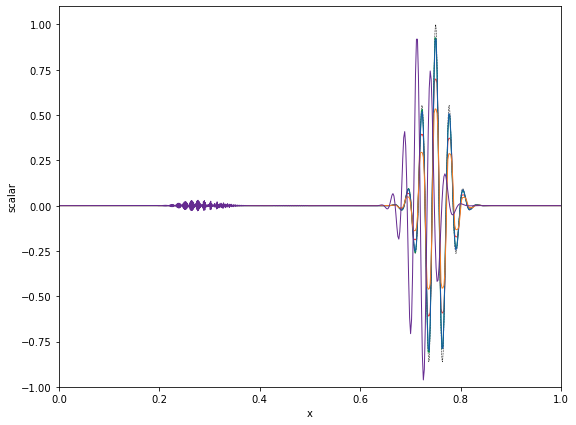

In [21]:
fig,ax = plt.subplots(figsize=(9,7))
ax.plot(x_exact,[gaussianwavepacket.exact_solution(x_i,0.5) for x_i in x_exact],label='exact',linewidth=lw_exact,linestyle=ls_exact,color='black')
postprocessing.batch_plot_ray(ax,root_dir,case_dir,methods,grid_sizes,-1,(0,0,0),(1,0,0),use_ray_coord=False,color_methods=True)
ax.set_xlim(0,1)
ax.set_ylim(-1.0,1.1)
ax.set_xlabel('x')
ax.set_ylabel('scalar')
fig.savefig(f'figures/{gaussianwavepacket.name}_fine_to_coarse_distribution.png',dpi=300)

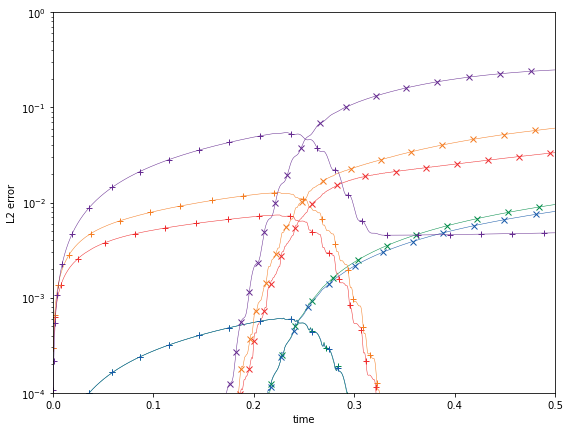

In [22]:
fig,ax = plt.subplots(figsize=(9,7))
postprocessing.batch_plot_error(ax,'error.log',root_dir,case_dir,methods,grid_sizes,0.5,with_global=False,max_level=1,line_width=0.5)
ax.set_ylim(1e-4,1e-0)
ax.set_xlim(0,0.5)
ax.set_yscale('log')
ax.set_xlabel('time')
ax.set_ylabel('L2 error')
fig.savefig(f'figures/{gaussianwavepacket.name}_fine_to_coarse_error.png',dpi=300)

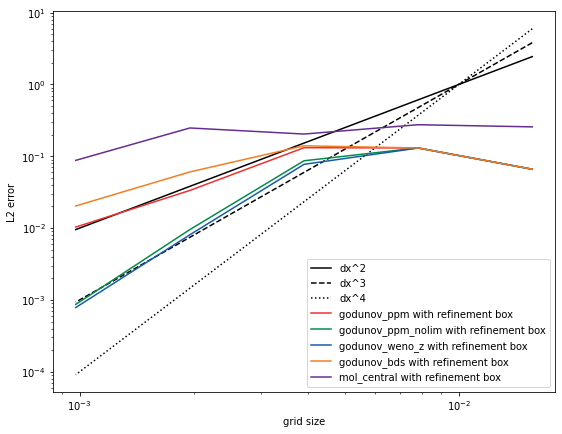

In [23]:
grid_sizes = [64,128,256,512,1024]
dx_list = [1.0/grid_size for grid_size in grid_sizes]
fig,ax = plt.subplots(figsize=[9,7])
error_list = postprocessing.batch_load_error('error.log',root_dir,case_dir,methods,grid_sizes,load_global=True)
ax.plot(dx_list,[1e4*dx**2 for dx in dx_list],label='dx^2',linestyle='solid',color='black')
ax.plot(dx_list,[1e6*dx**3 for dx in dx_list],label='dx^3',linestyle='dashed',color='black')
ax.plot(dx_list,[1e8*dx**4 for dx in dx_list],label='dx^4',linestyle='dotted',color='black')
for i_method in range(len(methods)):
    ax.plot([1/grid_size for grid_size in grid_sizes],[df_error_grid['error_global'].values[-1] for df_error_grid in error_list[i_method]],label=f'{methods[i_method]} with refinement box',color=postprocessing.color_list[i_method])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('L2 error')
ax.set_xlabel('grid size')
ax.legend()
fig.savefig(f'figures/{gaussianwavepacket.name}_fine_to_coarse_convergence.png',dpi=300)

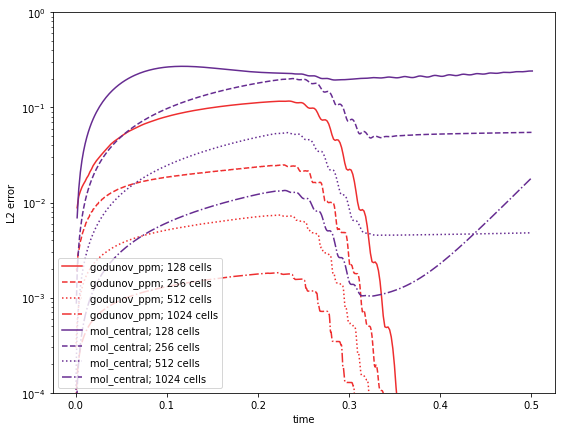

In [24]:
fig,ax = plt.subplots(figsize=(9,7))
grid_sizes = [128,256,512,1024]
for i_method in [0,4]:
    error_list = postprocessing.batch_load_error('error.log',root_dir,case_dir,[methods[i_method]],grid_sizes,load_global=False)
    for i_grid_size in range(len(grid_sizes)):
        ax.plot(error_list[0][i_grid_size]['time'].values,error_list[0][i_grid_size]['error_level_1'].values,color=postprocessing.color_list[i_method],linestyle=postprocessing.line_style_list[i_grid_size],label=f'{methods[i_method]}; {grid_sizes[i_grid_size]} cells')
ax.set_yscale('log')
ax.set_ylim(1e-4,1e-0)
ax.legend(loc='lower left')
ax.set_ylabel('L2 error')
ax.set_xlabel('time')
ax.set_xlabel('time')
ax.set_ylabel('L2 error')
fig.savefig(f'figures/{gaussianwavepacket.name}_fine_to_coarse_level_1_comparison.png',dpi=300)

Animation example:

In [25]:
import matplotlib.animation
from matplotlib.animation import FuncAnimation

In [26]:
grid_sizes = [512]
methods = ['mol_central']
case_dir = gaussianwavepacket.name+"/fine_to_coarse"
plt_count_list = postprocessing.batch_plt_count(root_dir,case_dir,methods,grid_sizes)
minpltcount = min([plt_count_grid_size for plt_count_method in plt_count_list for plt_count_grid_size in plt_count_method])
max_level = 1
with_global = False

In [27]:
def init_animation():
    for line in lines:
        line.set_data([],[])
    return lines

In [28]:
%%capture
plt.rcParams["animation.html"] = "jshtml"
fig,axs = plt.subplots(1,2,figsize=(20,7))
lines1 = postprocessing.setup_batch_line_plot(axs[0],methods,grid_sizes,as_error_lines=False)
lines2 = postprocessing.setup_batch_line_plot(axs[1],methods,grid_sizes,as_error_lines=True,max_level=max_level,with_global=withglobal)
lines = lines1 + lines2
axs[0].set_xlim(0,1)
axs[0].set_ylim(-1,1.1)
axs[0].set_xlabel('x')
axs[0].set_ylabel('scalar')
axs[1].set_yscale('log')
axs[1].set_xlim(0,0.5)
axs[1].set_ylim(1e-3,1e-0)
axs[1].set_xlabel('time')
axs[1].set_ylabel('L2 error')

def animate(i):
    ds_list = postprocessing.batch_load_plt(root_dir,case_dir,methods,grid_sizes,i)
    df_list = [postprocessing.sample_ray(ds,[0,0,0],[1,0,0]) for ds_method in ds_list for ds in ds_method]
    error_df_list = postprocessing.batch_load_error('error.log',root_dir,case_dir,methods,grid_sizes,load_global=with_global)
    times = [df['time'].values[-1] for df in df_list]
    postprocessing.batch_set_ray_data(lines[:len(lines1)],df_list)    
    postprocessing.batch_set_error_data(lines[len(lines1):],error_df_list,times[0],max_level=max_level,with_global=with_global)
    return lines

anim = FuncAnimation(fig, animate, init_func=init_animation, frames=minpltcount, interval=100, blit=True)

In [29]:
anim